***IMPORTING LIBRARIES***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# utilities
import re
import numpy as np
import pandas as pd
from collections import Counter
import itertools

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# nltk
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#keras
import keras 
from keras.preprocessing.text import Tokenizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***IMPORTING DATA***


The dfg used is the sentiment140 df. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this df may have lower than expected accuracy, since the df isn't perfectly categorised.]

It contains the following 6 fields:

    sentiment: the polarity of the tweet (0 = negative, 4 = positive)
    ids: The id of the tweet (2087)
    date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
    flag: The query (lyx). If there is no query, then this value is NO_QUERY.
    user: the user that tweeted (robotickilldozr)
    text: the text of the tweet (Lyx is cool)

We require only the sentiment and text fields, so we discard the rest.

Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (0 = Negative, 1 = Positive)

In [4]:
df_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
df_ENCODING = "ISO-8859-1"
df = pd.read_csv(r'/content/drive/MyDrive/twitter.csv',
                      encoding=df_ENCODING , names=df_COLUMNS)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df['sentiment'].unique()

array([0, 4])

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

df.sentiment = df.sentiment.apply(lambda x: decode_sentiment(x))


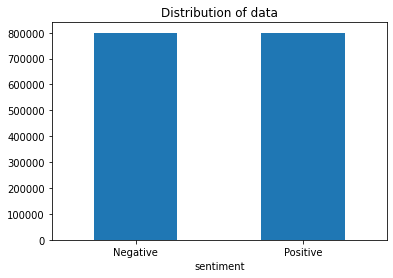

In [8]:
# Removing the unnecessary columns.
df = df[['sentiment','text']]
# Replacing the values to ease understanding.
df['sentiment'] = df['sentiment'].replace(4,1)

# Plotting the distribution for df.
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(df['text']), list(df['sentiment'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  object
 1   text       1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


**TEXT PREPROCESSING**

Text Preprocessing is traditionally an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

   1.  Lower Casing: Each text is converted to lowercase.
   2.  Replacing URLs: Links starting with "http" or "https" or "www" are replaced by "URL".
   3. Replacing Emojis: Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
   4. Replacing Usernames: Replace @Usernames with word "USER". (eg: "@Kaggle" to "USER")
   5. Removing Non-Alphabets: Replacing characters except Digits and Alphabets with a space.
   6. Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
   7. Removing Short Words: Words with length less than 2 are removed.
   8. Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
   9. Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)


In [10]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


In [11]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)


In [12]:
df.text = df.text.apply(lambda x: preprocess(x))

In [13]:
df.text

0               awww bummer shoulda got david carr third day
1          upset update facebook texting might cry result...
2          dived many times ball managed save 50 rest go ...
3                           whole body feels itchy like fire
4                                           behaving mad see
                                 ...                        
1599995                        woke school best feeling ever
1599996             thewdb com cool hear old walt interviews
1599997                      ready mojo makeover ask details
1599998    happy 38th birthday boo alll time tupac amaru ...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, Length: 1600000, dtype: object

**SPLITTING THE DATA**

The Preprocessed Data is divided into 2 sets of data:

    Training Data: The dataset upon which the model would be trained on. Contains 80% data.
    Test Data: The dataset upon which the model would be tested against. Contains 20% data.


In [14]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [15]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [16]:
train_data.head()

,sentiment,text
23786,NEGATIVE,need friends
182699,NEGATIVE,im trying call impossible
476661,NEGATIVE,good pace going 3k 13 min missed 5k turn ended...
1181490,POSITIVE,u gonna shows ny soon luv see u live
878773,POSITIVE,hell yea get em tattoos ink free wish parents ...


In [17]:
tre = train_data.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
tre.style.background_gradient(cmap='Blues')

,sentiment,text
1,POSITIVE,640542
0,NEGATIVE,639458


In [18]:
fig = go.Figure(go.Funnelarea(
    text =tre.sentiment,
    values = tre.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [19]:
test_data.head()

,sentiment,text
709290,NEGATIVE,feelin lately reason
654075,NEGATIVE,ju clare elly zoe leave marbella
728623,NEGATIVE,wish couldve seen miley nick sing 2night
697650,NEGATIVE,work today 1 hour 6 go
1244425,POSITIVE,started catch house viewing kind odd watched b...


**TRAINING DATA EXPLORATION**

In [20]:
train_data['temp_list'] = train_data['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')



,Common_words,count
0,good,73254
1,day,69618
2,get,65523
3,like,62724
4,go,59057
5,quot,57910
6,today,54670
7,work,51928
8,love,51868
9,going,51522


In [21]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [22]:
train_data['sentiment'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [23]:
Positive_sent = train_data[train_data['sentiment']=='POSITIVE']
Negative_sent = train_data[train_data['sentiment']=='NEGATIVE']


In [24]:
#MosT common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,49864
1,love,38187
2,day,37790
3,quot,36844
4,like,29988
5,get,29166
6,lol,28752
7,thanks,27670
8,u,25553
9,going,24621


In [25]:
fig = px.treemap(temp_positive, path=['Common_words'], values='count',title='Tree Of Most Common Positive Words')
fig.show()

In [26]:
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,get,36357
2,work,36353
3,like,32736
4,day,31828
5,today,30460
6,going,26901
7,back,26532
8,got,26479
9,really,25097
10,miss,24557


In [27]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count',title='Tree Of Most Common Negative Words')
fig.show()

**ANALYSING THE DATA WITH WORDCLOUD**

Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot Word Clouds for Positive and Negative tweets from our dataset and see which words occur the most.

In [28]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(10.0,12.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

**WORD CLOUD FOR POSITIVE TWEETS**

In [29]:
mask = np.array(Image.open('/content/drive/MyDrive/twitter_mask3.png'))

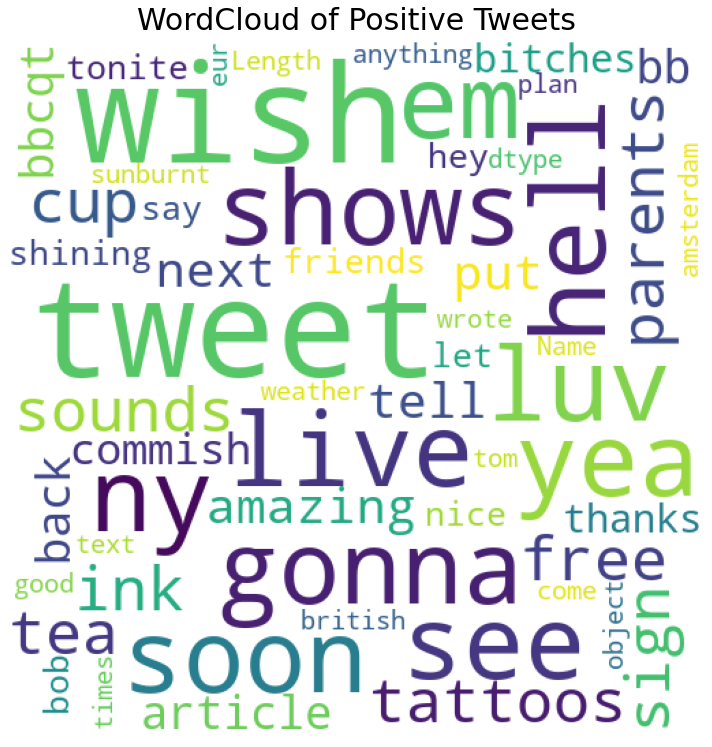

In [30]:
plot_wordcloud(Positive_sent.text,mask=mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Positive Tweets")

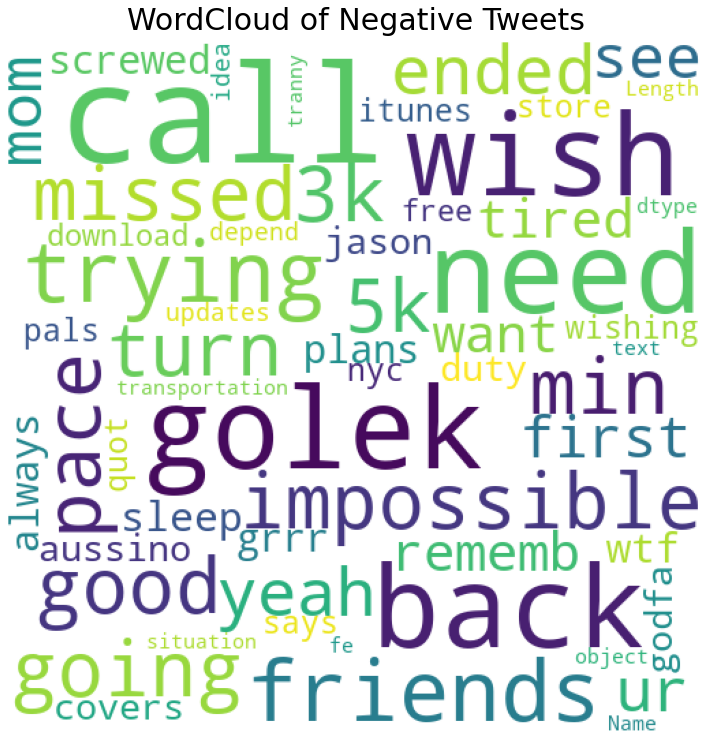

In [31]:
plot_wordcloud(Negative_sent.text,mask=mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Negative Tweets")

**ANALYSIS ON SPLITTING OF DATA INTO X_TRAIN , Y_TRAIN ,
X_TEST , Y_TEST**

**TOKENISATION**

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. The process is called **Tokenization**. 

Tokenizer create tokens for every word in the data corpus and map them to a index using dictionary.

**a.** word_index contains the index for each word

**b.** vocab_size represents the total number of word in the data corpus

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)


Total words 290575


**LABEL ENCODING**

We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [33]:
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'].tolist())


In [34]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],df['sentiment'], test_size = 0.20, random_state = 42)

In [35]:
len(X_train),len(X_test),len(y_train),len(y_test)

(1280000, 320000, 1280000, 320000)

**TF-IDF VECTORIZATION**

TF-IDF indicates what the importance of the word is in order to understand the document or dataset. Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

1.TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

2.ngram_range is the range of number of words in a sequence. [e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]

3.max_features specifies the number of features to consider. [Ordered by feature frequency across the corpus].

In [36]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



No. of feature_words:  500000


In [37]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


**EVALUATING THE MODELS**

Since our dataset is not skewed, i.e. it has equal number of Positive and Negative Predictions. We're choosing Accuracy as our evaluation metric. Furthermore, we're plotting the Confusion Matrix to get an understanding of how our model is performing on both classification types.

In [38]:
def model_Evaluate(model):
    
    # Predict values for Test data
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the data
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**BERNOULINB  MODEL**

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           1       0.77      0.80      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



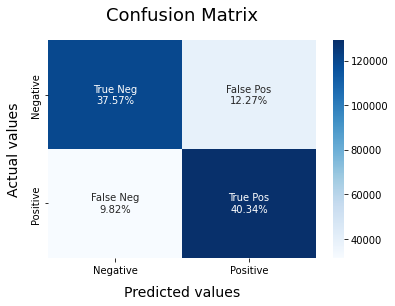

In [39]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

**LINEAR SVC MODEL**

              precision    recall  f1-score   support

           0       0.78      0.76      0.77    159494
           1       0.77      0.79      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



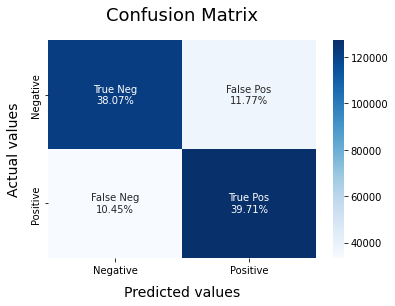

In [40]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

**LOGISTIC REGRESSION MODEL**

              precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           1       0.78      0.81      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



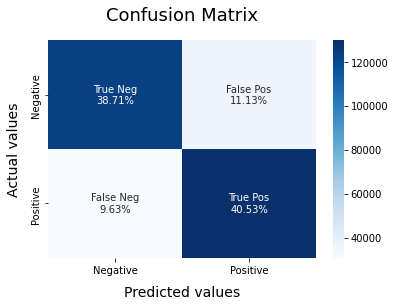

In [41]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

**NAIVE BAYES CLASSIFIER**

              precision    recall  f1-score   support

           0       0.78      0.78      0.78    159494
           1       0.78      0.78      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



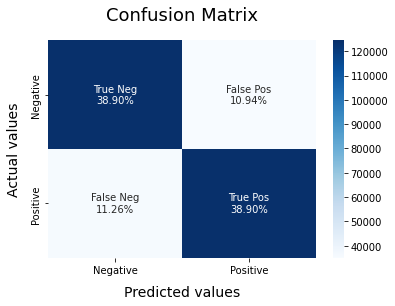

In [42]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)

**XG BOOST CLASSIFIER**

              precision    recall  f1-score   support

           0       0.79      0.46      0.58    159494
           1       0.62      0.88      0.73    160506

    accuracy                           0.67    320000
   macro avg       0.71      0.67      0.65    320000
weighted avg       0.71      0.67      0.65    320000



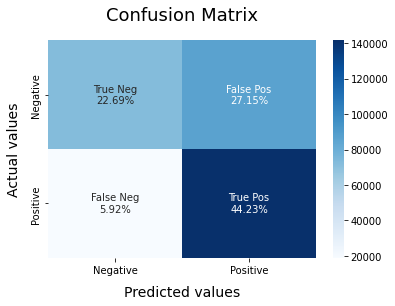

In [43]:
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)
model_Evaluate(xg)

**CONCLUSION**


From the above analysis of twitter data we can say our predict the sentiment of tweets with the accuracy of almost 67-79 percent where the accuracy can be listed as :
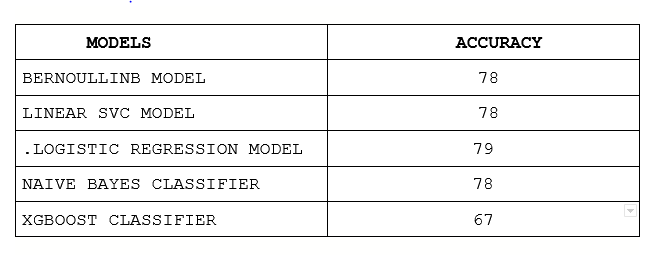
              
   


Further classifiers can also verified if u want to check the accuracy of the data.

**COMBINED PROGRAM FOR ALL ALGORITHMS**

In [44]:
"""from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve """

In [45]:
""" MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model. RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
   #tree.ExtraTreeClassifier(),
    
    ] """

In [ ]:
"""MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)


row_index = 0
for alg in MLA:
    
    
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    MLA_compare.loc[row_index, 'MLA Precission'] = precision_score(y_test, predicted)
    MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(y_test, predicted)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)





    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare """

**KNN CLASSIFIER**

In [ ]:
#from sklearn.neighbors import KNeighborsClassifier
#kn = KNeighborsClassifier()
#kn.fit(X_train, y_train)
#model_Evaluate(kn)

**SUPPORT VECTOR MACHINES**

In [ ]:
#from sklearn.svm import SVC
#sv = SVC()
#sv.fit(X_train, y_train)
#model_Evaluate(sv)

**RANDOM FOREST CLASSIFIER**

In [ ]:
#rf = RandomForestClassifier()
#rf.fit(X_train, y_train)
#model_Evaluate(rf)

**DECISION TREE CLASSIFIER**

In [ ]:
#dc= DecisionTreeClassifier()
#dc.fit(X_train, y_train)
#model_Evaluate(dc)

**LAZY PREDICT  ALGORITHM**

This algorithm gives the classification report of 30 different clasifiers in a dataframe which is very helpful still it requires high ram availability and a little time consuming process but gives almost accurate output


In [ ]:
#import lazypredict
#from lazypredict.Supervised import LazyClassifier 

#x = df.drop(['sentiment'],1)
#y = df.sentiment
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

#clf = LazyClassifier(verbose=0,ignore_warnings=True)
#models, predictions = clf.fit(X_train, X_test, y_train, y_test)
#model